In [1]:
import numpy as np
import pandas as pd
import time
import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from boris_util import *

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Exploring the Dataset

First thing's first, let's load the dataset. I created a new function that loads up the dataset for me and converts it into a pandas dataframe for easy access. For more information on this, please see the `Data Cleaning` notebook

In [3]:
dataset = read_and_combine_data('453_923_bundle_archive', read_noisy_data=False)
print(dataset.shape)
dataset.head()

processed 100.00%
(436, 3)


,signal,sampling_rate,label
0,"[2.2960085e-05, -0.00012982322, -0.00018070513...",22050,artifact
1,"[-1.0927635e-05, 1.0574424e-06, 2.108567e-06, ...",22050,artifact
2,"[3.728857e-05, -0.0001664555, -7.4023155e-05, ...",22050,artifact
3,"[-0.0027429417, -0.0066496185, -0.0049779303, ...",22050,artifact
4,"[0.000106223946, 0.0015002153, 0.0097254915, 0...",22050,artifact


Let's take a look at the class distribution to see if there is any concern of class imbalance

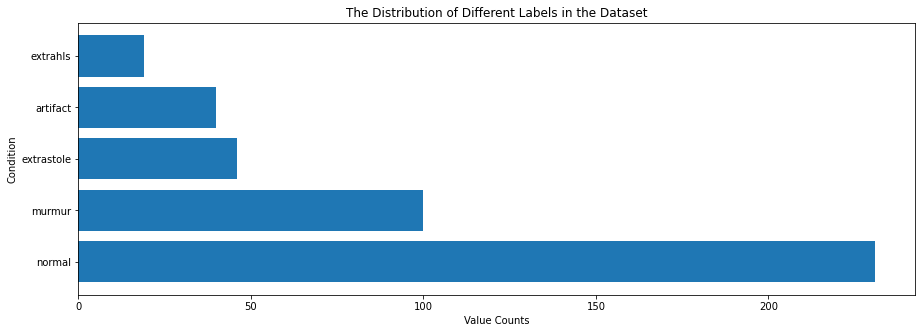

In [4]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Dataset")
plt.show()

There is certainly an issue of class imbalance here. A naive classifier could guess pretty well by simply guessing "Normal" on all the examples

## Combine all Abnormalities

Let's try a simple example first, we will combine all abnormalities into a single label "abnormal". We won't count artifacts in that category

In [5]:
def relabel(label):
    if (label == "normal"):
        return "normal"
    else:
        return "abnormal"
dataset['label'] = dataset['label'].apply(relabel)

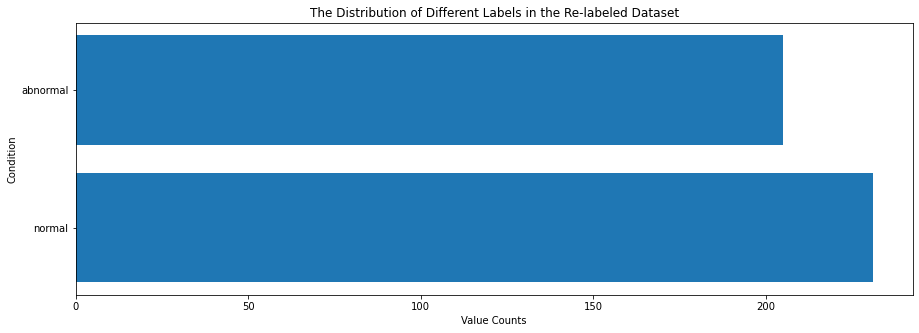

In [6]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Re-labeled Dataset")
plt.show()

Let's split our data now into a simple train/test stratified split

In [7]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, stratify=dataset['label'], random_state=1)
print(train_dataset.shape)
print(test_dataset.shape)

(305, 3)
(131, 3)


In [8]:
train_dataset.head()

,signal,sampling_rate,label
302,"[-0.014594975, -0.016623363, -0.017930867, -0....",22050,normal
401,"[0.00535502, 0.0048318487, 0.0038144102, 0.002...",22050,normal
311,"[-0.0009814408, -0.00052338943, 9.0988244e-05,...",22050,normal
346,"[-0.007578952, -0.011004641, -0.015165693, -0....",22050,normal
410,"[-0.030912954, -0.033952978, -0.035377894, -0....",22050,normal


## Dataset Augmentation

We won't get very far with the examples we have. There aren't very many of them

Luckily, we can easily augment the dataset by shifting the data and/or adding some noise

In [9]:
DATASET_TARGET = 1000

In [10]:
# find the label ratios
inverse_counts = 1/train_dataset['label'].value_counts()
probability_counts = inverse_counts/inverse_counts.sum()
probability_counts

normal      0.468852
abnormal    0.531148
Name: label, dtype: float64

In [11]:
#https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6
    
def shift_sound(data, sampling_rate, shift_max, shift_direction='right'):
    shift = np.random.randint(int(shift_max * data.shape[0]))
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data = augmented_data[shift:]
    else:
        augmented_data = augmented_data[:shift]
    return augmented_data

In [12]:
choices = np.random.choice(probability_counts.index, 
                           p=probability_counts.values, 
                           size=(DATASET_TARGET,))
i = 0
while train_dataset.shape[0] < DATASET_TARGET:
    choice = choices[i]
    available_instances = train_dataset[train_dataset['label'] == choice]
    selected_row_position = np.random.randint(available_instances.shape[0])
    
    selected_row = available_instances.iloc[selected_row_position]
    
    base_signal = selected_row['signal']
    sampling_rate = selected_row['sampling_rate']
    
    shift_direction = 'both'
    new_signal = shift_sound(base_signal, sampling_rate, (np.random.random()*0.3), shift_direction)
    if (new_signal.shape[0] > 0):
    
        new_series = pd.Series({'signal' :new_signal, 'sampling_rate': sampling_rate, 'label': choice})
        train_dataset = train_dataset.append(new_series, ignore_index=True)
    
        print(train_dataset.shape, end="\r")
    i+= 1

Now let's define a class which will convert the signals into Mel spectrograms

In [21]:
class MelEncoder:
    
    '''
        This transformer takes an audio signal and employes librosa
        to transform the audio signal into a Mel-frequency spectrogram.
        
        The transformation transforms the audio signal from samples in a 
        time domain, to frequencies over each time window. The frequencies
        are then collected into buckets which are easily distinguished by
        human hearing
    '''
    
    def __init__(self, flatten=True, n_fft=2048, hop_length=512, n_mels=128, sampling_rate=22050.0, n_windows=1000, verbose=0):
        
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sampling_rate = sampling_rate
        self.n_windows = n_windows
        self.verbose = verbose
        
        
        self.flatten = flatten
        
    
    def fit(self, X, y=None):
        '''
            This method doesn't do much except initialize
        '''
        self.longest_signal_length = None
        
    
    
    def _create_spectrogram_list(self, X):
        
        spectrogram_list = []
        
        
        for i, signal in enumerate(X):
                mel_spectrogram = self._signal_to_mel_spectrogram(signal)
                spectrogram_list.append(mel_spectrogram)
                if (self.verbose):
                    print(f"{round(100*i/X.shape[0], 2)}%", end="\r")
                    
                
        print(f"{round(100*i/X.shape[0], 2)}%")
        
        return spectrogram_list
    
    
    def _find_longest_signal_length(self, spectrogram_list):
        
        max_length = 0
        for mel_spectrogram in spectrogram_list:
            if (mel_spectrogram.shape[1] > max_length):
                max_length = mel_spectrogram.shape[1]

        return max_length
            
    def _build_mel_spectrogram_stack(self, spectrogram_list):
        
        X_transformed = np.zeros((len(spectrogram_list), self.n_mels, self.longest_signal_length))
        
        for i, mel_spectrogram in enumerate(spectrogram_list):
            if (mel_spectrogram.shape[1] <= self.longest_signal_length):
                X_transformed[i, :, -mel_spectrogram.shape[1]:] = mel_spectrogram[:, :]
            else:
                X_transformed[i, :, :] = mel_spectrogram[:, -self.longest_signal_length:]
                
        return X_transformed
    
    
    def transform(self, X):
        
        spectrogram_list = self._create_spectrogram_list(X)
        
        if (self.longest_signal_length is None):
            self.longest_signal_length = self._find_longest_signal_length(spectrogram_list)
            
        X_transformed = self._build_mel_spectrogram_stack(spectrogram_list)
        
        
        if (self.flatten):
            return X_transformed.reshape(X_transformed.shape[0], -1)
        else:
            return X_transformed
        
        
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
        
        
        
        
    # https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
    def _longest_signal(self, signals):
        max_length = 0
        for signal in signals:
            if (len(signal) > max_length):
                max_length = len(signal)

        return max_length
    
    
    def _signal_to_mel_spectrogram(self, signal):
        
        
        if (self.n_windows is not None):
            hop_length = signal.shape[0]//self.n_windows
        else:
            hop_length = self.hop_length
        S = librosa.feature.melspectrogram(signal, 
                                           sr=self.sampling_rate, 
                                           n_fft=self.n_fft, 
                                           hop_length=hop_length, 
                                           n_mels=self.n_mels)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return S_DB

In [22]:
my_encoder = MelEncoder(n_mels=128, n_windows=1000, verbose=1)

In [23]:
my_encoder.fit(train_dataset['signal'])

In [24]:
X_train_mel = my_encoder.transform(train_dataset['signal'])

99.9%


In [25]:
X_train_mel.shape

(1000, 137088)

In [26]:
X_test_mel = my_encoder.transform(test_dataset['signal'])

99.24%


In [27]:
X_test_mel.shape

(131, 137088)

## PCA

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
my_mmscaler = MinMaxScaler()

X_train_mel = my_mmscaler.fit_transform(X_train_mel)
X_test_mel = my_mmscaler.transform(X_test_mel)

In [30]:
X_train_mel = X_train_mel
X_train_mel.shape

(1000, 137088)

In [31]:
%%time 

component_number = min(*X_train_mel.shape)
my_pca = PCA(n_components=component_number, svd_solver='randomized')
my_pca.fit(X_train_mel)

Wall time: 9min 34s
Parser   : 118 ms


PCA(n_components=1000, svd_solver='randomized')

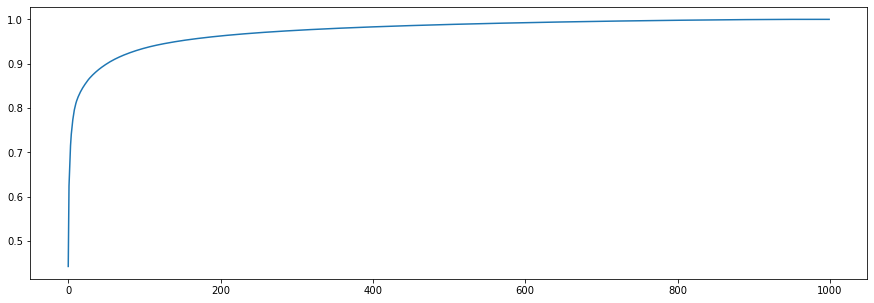

In [32]:
plt.figure(figsize=(15,5))
plt.plot(my_pca.explained_variance_ratio_.cumsum())
plt.show()

In [33]:
X_train_mel = my_pca.transform(X_train_mel)
X_test_mel = my_pca.transform(X_test_mel)

In [34]:
X_train_mel.shape

(1000, 1000)

In [35]:
X_test_mel.shape

(131, 1000)

## Basic Model - Logistic Regression

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [36]:
condition_label_encoder = LabelEncoder()


y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(1000, 1000) (131, 1000)
(1000,) (131,)


In [37]:
%%time

my_logit = LogisticRegression(random_state=1).fit(X_train_mel, y_train)
train_acc = my_logit.score(X_train_mel, y_train)
test_acc = my_logit.score(X_test_mel, y_test)

Wall time: 2.28 s


In [38]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 100.0%
The test accuracy is 61.07%


Extremely suspicious results. There is clearly a very large sign of overfitting here. Let's explore how the logistic regression makes decisions.

Let's plot the coefficients as if they were an audio mask (which is really what they end up becoming).

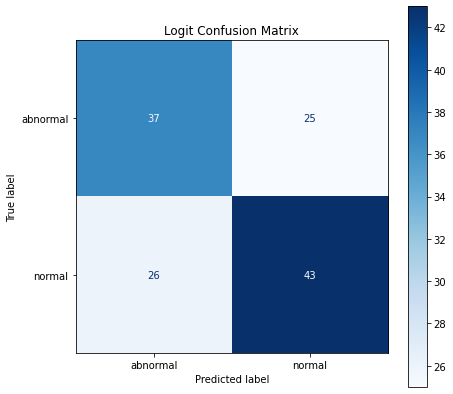

In [39]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

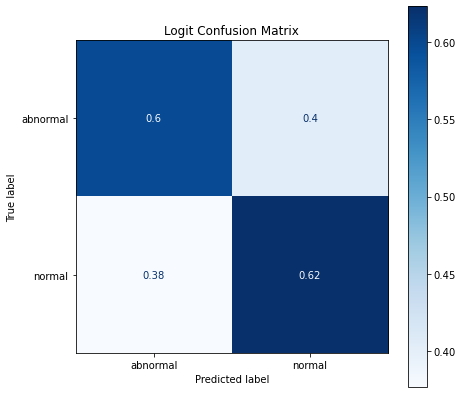

In [40]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [41]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [10**i for i in range(-7, 8)]}
my_estimator = LogisticRegression(solver='saga')
my_logit_gs = GridSearchCV(my_estimator, param_grid, cv=5, verbose=1, n_jobs=3)

In [42]:
%%time
my_logit_gs.fit(X_train_mel, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   35.7s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:  2.6min finished


Wall time: 2min 42s


GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'), n_jobs=3,
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                               10, 100, 1000, 10000, 100000, 1000000,
                               10000000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [43]:
my_logit_gs.best_params_

{'C': 1, 'penalty': 'l1'}

In [44]:
train_acc = my_logit_gs.score(X_train_mel, y_train)
test_acc = my_logit_gs.score(X_test_mel, y_test)

In [45]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 89.3%
The test accuracy is 63.36%


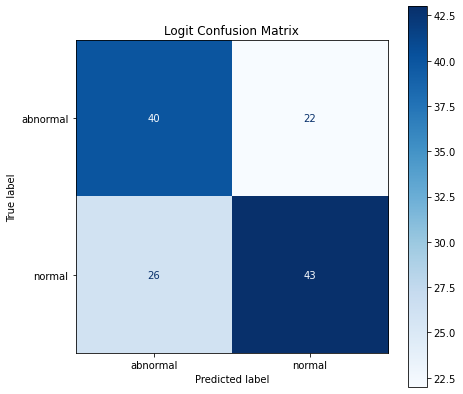

In [46]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

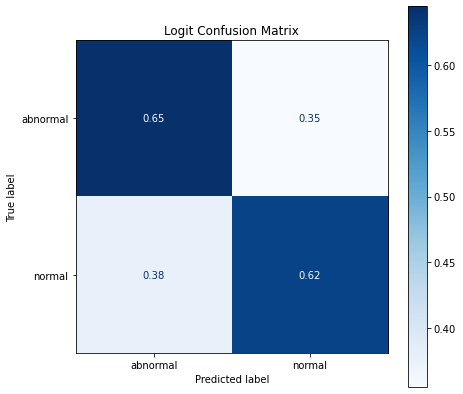

In [47]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [48]:
print(classification_report(y_test, my_logit_gs.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.61      0.65      0.62        62
           1       0.66      0.62      0.64        69

    accuracy                           0.63       131
   macro avg       0.63      0.63      0.63       131
weighted avg       0.64      0.63      0.63       131



In [49]:
y_proba = my_logit_gs.predict_proba(X_test_mel)

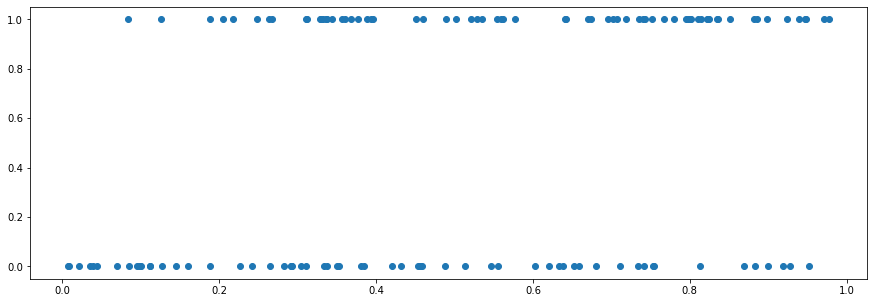

In [50]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], y_test)
plt.show();

## Basic Model - Support Vector Machine

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [51]:
condition_label_encoder = LabelEncoder()


y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(1000, 1000) (131, 1000)
(1000,) (131,)


In [52]:
%%time

my_svm = SVC(random_state=1, max_iter=10000, probability=True).fit(X_train_mel, y_train)
train_acc = my_svm.score(X_train_mel, y_train)
test_acc = my_svm.score(X_test_mel, y_test)

Wall time: 15 s


In [53]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 85.6%
The test accuracy is 74.05%


Extremely suspicious results. There is clearly a very large sign of overfitting here. Let's explore how the logistic regression makes decisions.

Let's plot the coefficients as if they were an audio mask (which is really what they end up becoming).

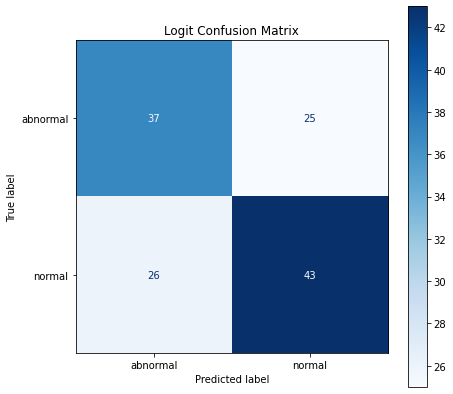

In [54]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

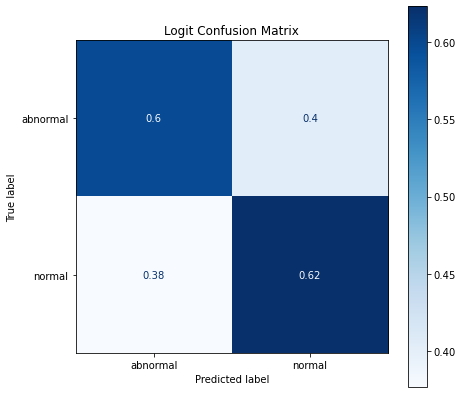

In [55]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [56]:
param_grid = {'C': [10**i for i in range(-7, 8)],
              'kernel': ['poly', 'rbf', 'sigmoid'],
              'degree': [i for i in range(2, 6)]}
my_estimator = SVC(max_iter=10000, probability=True)
my_svm_gs = GridSearchCV(my_estimator, param_grid, cv=5, verbose=1, n_jobs=3)

In [ ]:
%%time
my_svm_gs.fit(X_train_mel, y_train);

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 10.2min


In [ ]:
my_svm_gs.best_params_

In [ ]:
train_acc = my_svm_gs.score(X_train_mel, y_train)
test_acc = my_svm_gs.score(X_test_mel, y_test)

In [ ]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_svm_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_svm_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_test, my_svm_gs.predict(X_test_mel)))

In [ ]:
y_proba = my_svm_gs.predict_proba(X_test_mel)

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], y_test)
plt.show();

## Basic Model - Support Vector Machine

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [ ]:
condition_label_encoder = LabelEncoder()


y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [ ]:
%%time

my_knn = KNN().fit(X_train_mel, y_train)
train_acc = my_knn.score(X_train_mel, y_train)
test_acc = my_knn.score(X_test_mel, y_test)

In [ ]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

Extremely suspicious results. There is clearly a very large sign of overfitting here. Let's explore how the logistic regression makes decisions.

Let's plot the coefficients as if they were an audio mask (which is really what they end up becoming).

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_knn, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_knn, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
param_grid = {'knn__n_neighbors': [i for i in range(3,10)] + \
                             [i for i in range(10, 100, 5)] + \
                             [i for i in range(100, X_train_mel.shape[0]//2, 20)],
              'knn__weights': ['uniform', 'distance']}

my_pipe = Pipeline([('scaler', MinMaxScaler()),
                    ('knn', KNN(algorithm='auto'))])

my_knn_gs = GridSearchCV(my_pipe, param_grid, cv=10, verbose=1, n_jobs=3)

In [ ]:
%%time
my_knn_gs.fit(X_train_mel, y_train);

In [ ]:
my_knn_gs.best_params_

In [ ]:
train_acc = my_knn_gs.score(X_train_mel, y_train)
test_acc = my_knn_gs.score(X_test_mel, y_test)

In [ ]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_knn_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_knn_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_test, my_knn_gs.predict(X_test_mel)))

In [ ]:
y_proba = my_knn_gs.predict_proba(X_test_mel)

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], y_test)
plt.show();

## Basic Model - Decision Tree

As another baseline, I will train a decision tree to see if introducing non-linearity to the learning process produces better results

In [ ]:
print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

In [ ]:
%%time 

# Let's set some regularization otherwise we know the tree will overfit
my_tree = DecisionTreeClassifier()
param_grid = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)]}

my_tree_gs = GridSearchCV(my_tree, param_grid, cv=5, verbose=1, n_jobs=3)
my_tree_gs.fit(X_train_mel, y_train)


train_acc = my_tree_gs.score(X_train_mel, y_train)
test_acc = my_tree_gs.score(X_test_mel, y_test)

In [ ]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

In [ ]:
my_tree_gs.best_params_

Much better results! However, let's see how the model performs using the confusion matrix of the test set



In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_tree_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_tree_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

As suspected, quite a bit of the classification seems to classify abnormal conditions and sounds as "normal" due to the sheer volume of that class, but interestingly, ~39% of the normal examples get misclassified as abnormalities.

In [ ]:
print(classification_report(y_test, my_tree_gs.predict(X_test_mel)))

In [ ]:
y_proba = my_tree_gs.predict_proba(X_test_mel)

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], 
            y_test)
plt.show();

## Advanced Model - Random Forest

...

In [ ]:
print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

In [ ]:
%%time 

# Let's set some regularization otherwise we know the tree will overfit
my_rf = RandomForestClassifier(min_samples_leaf=10, 
                               max_features=0.6,
                               max_depth=901,
                               random_state=1, 
                               n_estimators=350,
                               verbose=1,
                               n_jobs=3).fit(X_train_mel, y_train)


train_acc = my_rf.score(X_train_mel, y_train)
test_acc = my_rf.score(X_test_mel, y_test)

In [ ]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

Much better results! However, let's see how the model performs using the confusion matrix of the test set



In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_rf, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Gradient Boosting Confusion Matrix")
plt.show()

In [ ]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_rf, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Gradient Boosting Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_test, my_rf.predict(X_test_mel)))

In [ ]:
y_proba = my_rf.predict_proba(X_test_mel)

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], 
            y_test)
plt.show();